In [68]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns


In [25]:
# load dataset
def load_dataset(image_dir, csv_file):
    data = pd.read_csv(csv_file)
    images = []
    labels = []
    for _, row in data.iterrows():
        image_filename = os.path.join(image_dir, f"image_{row['id']}.png")
        image = load_img(image_filename, target_size=(32, 32))
        image = img_to_array(image)
        images.append(image)
        labels.append(row['label'])
    images = np.array(images, dtype='float32') / 255.0
    labels = np.array(labels)
    return images, labels

def load_test_dataset(image_dir, test_size):
    images = []
    image_ids = []
    for i in range(test_size):
        image_filename = os.path.join(image_dir, f"image_{i}.png")
        image = load_img(image_filename, target_size=(32, 32))
        image = img_to_array(image)
        images.append(image)
        image_ids.append(i)
    images = np.array(images, dtype='float32') / 255.0
    return image_ids, images

train_image_dir = '/kaggle/input/nzmsa-2024/cifar10_images/train'
train_csv_file = '/kaggle/input/nzmsa-2024/train.csv'
test_image_dir = '/kaggle/input/nzmsa-2024/cifar10_images/test'
x_train, y_train = load_dataset(train_image_dir, train_csv_file)
y_train = to_categorical(y_train, 10)
image_ids, x_test = load_test_dataset(test_image_dir, 5000)

In [70]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Use this to create a validation set
)

In [71]:
# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    GlobalAveragePooling2D(),  # Use global average pooling instead of flatten
    
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model with data augmentation
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32, subset='training'),
    validation_data=datagen.flow(x_train, y_train, batch_size=32, subset='validation'),
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
1250/1250 [==============================] - 28s 21ms/step - loss: 2.7903 - accuracy: 0.3162 - val_loss: 2.5596 - val_accuracy: 0.3768
Epoch 2/100
1250/1250 [==============================] - 28s 22ms/step - loss: 2.3909 - accuracy: 0.4450 - val_loss: 2.2798 - val_accuracy: 0.4762
Epoch 3/100
1250/1250 [==============================] - 27s 22ms/step - loss: 2.1897 - accuracy: 0.4954 - val_loss: 2.1157 - val_accuracy: 0.5094
Epoch 4/100
1250/1250 [==============================] - 28s 22ms/step - loss: 2.0219 - accuracy: 0.5354 - val_loss: 2.1788 - val_accuracy: 0.4849
Epoch 5/100
1250/1250 [==============================] - 27s 22ms/step - loss: 1.8930 - accuracy: 0.5569 - val_loss: 1.9532 - val_accuracy: 0.5174
Epoch 6/100
1250/1250 [==============================] - 27s 22ms/step - loss: 1.7788 - accuracy: 0.5788 - val_loss: 1.6858 - val_accuracy: 0.6000
Epoch 7/100
1250/1250 [==============================] - 28s 23ms/step - loss: 1.6773 - accuracy: 0.5986 - val_loss: 1

In [72]:
# save the model
model.save('complete_model.keras')

In [73]:
# make the prediction
model.load_weights('complete_model.keras')
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)

submission = pd.DataFrame({'id': image_ids, 'label': predictions})
submission.to_csv('submission.csv', index=False)
print("Submission file has been created1.")

Submission file has been created1.


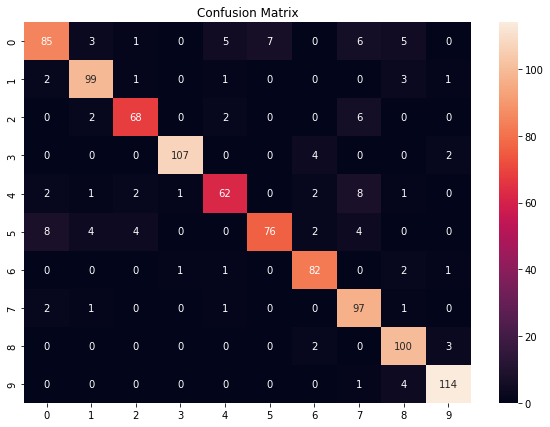

              precision    recall  f1-score   support

           0       0.86      0.76      0.81       112
           1       0.90      0.93      0.91       107
           2       0.89      0.87      0.88        78
           3       0.98      0.95      0.96       113
           4       0.86      0.78      0.82        79
           5       0.92      0.78      0.84        98
           6       0.89      0.94      0.92        87
           7       0.80      0.95      0.87       102
           8       0.86      0.95      0.90       105
           9       0.94      0.96      0.95       119

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



In [74]:
x_val = x_train[-1000:] 
y_val = y_train[-1000:]
y_pred_val = model.predict(x_val)
y_pred_classes_val = np.argmax(y_pred_val, axis=1)
y_true_val = np.argmax(y_val, axis=1)

# confusion matrix
cm = confusion_matrix(y_true_val, y_pred_classes_val)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

# classfication report
print(classification_report(y_true_val, y_pred_classes_val))

The confusion matrix displays the classification results of the model on the test set. Each row of the confusion matrix represents the actual class, and each column represents the predicted class. The elements in the matrix indicate the number of samples of the actual class that were predicted as a specific class. This matrix helps to understand which classes the model performs well on and where it makes errors.

For example, for class 0, 85 samples were correctly classified, 7 samples were incorrectly classified as class 4, and 6 samples were classified as class 7.
The diagonal numbers represent the number of correctly classified samples, and the higher these numbers, the better the model's performance for that class.

The classification report, showing the precision, recall, and F1-score for each class.

Precision: It indicates the proportion of true positive results among all samples that were predicted to be in a certain class. For example, the precision for class 1 is 0.90, meaning 90% of the samples predicted as class 1 are correct.
Recall: It indicates the proportion of true positive results among all samples that actually belong to a certain class. For example, the recall for class 1 is 0.93, meaning 93% of the actual class 1 samples were correctly classified.
F1-score: It is the harmonic mean of precision and recall, balancing the two metrics.
Overall, this classification report shows the model's overall accuracy is 0.89, with both macro and weighted averages also being 0.89, indicating the model performs consistently across different classes.

Summary

Training Process
Data Preparation: The dataset consists of CIFAR-10 images, resized to 32x32 pixels and normalized. Labels were converted to categorical format for classification.

Model Architecture: A Convolutional Neural Network (CNN) was designed with:

Convolutional layers (32, 64, 128, 256 filters) using ReLU activation, BatchNormalization, and MaxPooling.
A GlobalAveragePooling2D layer followed by a Flatten layer.
Dense layers with 512 and 256 neurons using ReLU activation and Dropout.
An output layer with 10 neurons and softmax activation for classification.
Optimization and Compilation: The model was compiled with the Adam optimizer (learning rate of 0.0001) and categorical cross-entropy loss.

Training: The model trained for 100 epochs with a batch size of 32 and 20% validation split. EarlyStopping and ReduceLROnPlateau callbacks were employed to mitigate overfitting and adjust learning rates.

Evaluation Process
Confusion Matrix: The confusion matrix showed the model’s detailed performance across all classes, indicating correct classifications and misclassifications. For example, class 0 had 85 correct predictions and some misclassifications into other classes.

Classification Report: Metrics such as precision, recall, and F1-score for each class were calculated, revealing an overall accuracy of 0.89. The macro and weighted averages for precision, recall, and F1-score were also around 0.89.

Observations
The model performed well across most classes, showing high precision and recall.
Some classes had lower recall, indicating a need for better identification of all actual positive samples.
An increase in validation loss during later epochs suggested potential overfitting.
Next Steps for Improvement
Data Augmentation: Apply random rotations, shifts, flips, and zooms to enhance the dataset, making the model more robust.

Regularization: Increase regularization strength or introduce L2 regularization to prevent overfitting.

Learning Rate Adjustment: Implement a learning rate scheduler to adjust the learning rate dynamically during training.

Model Architecture Tuning: Experiment with deeper or more complex architectures, such as additional convolutional layers or residual connections.

Hyperparameter Tuning: Use grid search or random search to optimize hyperparameters like learning rate, batch size, and dropout rates.

Ensemble Methods: Combine predictions from multiple models to improve performance and robustness.